In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
from scipy.stats import norm
import pandas as pd

In [2]:
S_max = 200
K = 100
T = 1.0
r = 0.05
sigma = 0.4

In [3]:
M = 100
N = 1_000

In [4]:
ds = S_max / M
dt = T / N

In [5]:
S = np.linspace(0, S_max, M + 1)
V = np.maximum(S - K, 0)
S.shape, V.shape

((101,), (101,))

In [6]:
j = np.arange(1, M)
A = 0.5 * dt * j * (r - sigma**2 * j)
B = 2 + dt * (r + sigma**2 * j**2)
C = -0.5 * dt * j * (r + sigma**2 * j)
A.shape, B.shape, C.shape

((99,), (99,), (99,))

In [7]:
A_lower = A[1:]
A_diag = B
A_upper = C[:-1]
A_matrix = np.diag(A_diag) + np.diag(A_lower, k=-1) + np.diag(A_upper, k=1)
A_matrix.shape

(99, 99)

In [8]:
_, L, U = lu(A_matrix)

In [9]:
b = np.zeros(M + 1)
for j in range(len(b)):
    if j == 0:
          continue
    if j == len(b) - 1:
            b[j] = V[-1]
            continue
    b[j] = -C[j-1] * V[j+1] + (4 - B[j-1]) * V[j] - A[j-1] * V[j-1]
    if (j == len(b) - 2):
            b[j] += -C[-1] * np.maximum(S[-1] - K, 0)

In [10]:
for n in range(N):
    V[-1] = S_max - K * np.exp(-r * (T - (n + 1) * dt))
    V[0] = 0

    W = np.linalg.solve(L, b[1:-1])
    V[1:-1] = np.linalg.solve(U, W)

    for j in range(len(b)):
        if j == 0:
            continue
        if j == len(b) - 1:
                b[j] = V[-1]
                continue
        b[j] = -C[j-1] * V[j+1] + (4 - B[j-1]) * V[j] - A[j-1] * V[j-1]
        if (j == len(b) - 2):
                b[j] += -C[-1] * np.maximum(S[-1] - K, 0)

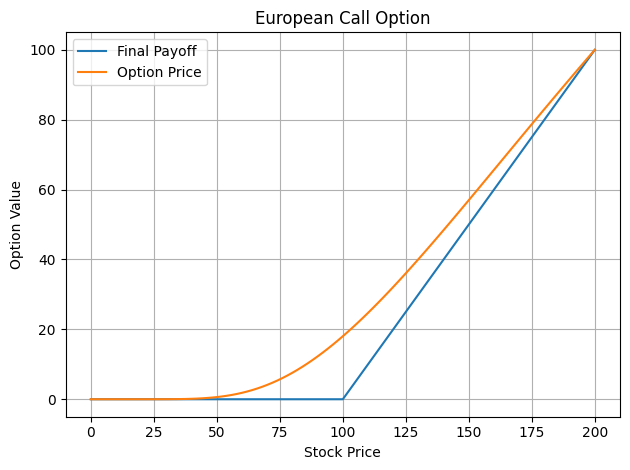

In [11]:
plt.plot(S, np.maximum(S - K, 0), label='Final Payoff')
plt.plot(S, V, label='Option Price')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('European Call Option')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/crank-nicolson.jpg', dpi=300)
plt.show()

In [12]:
def black_scholes(S, K, T, r, sigma):
    S = np.array(S)
    d1 = (np.log(S / K + 1e-12) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [13]:
black_scholes_prices = black_scholes(S, K, T, r, sigma)

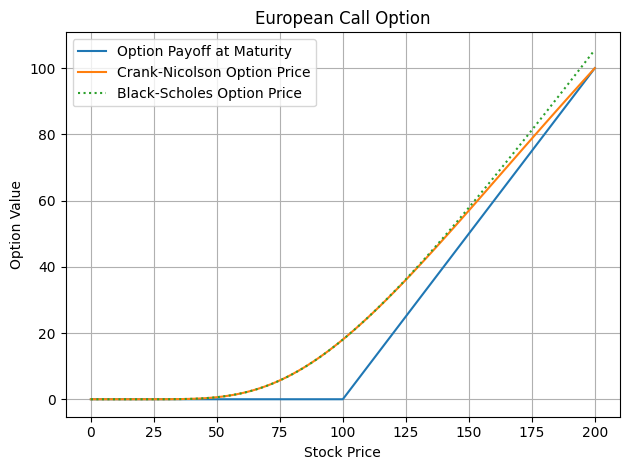

In [14]:
plt.plot(S, np.maximum(S - K, 0), label='Option Payoff at Maturity')
plt.plot(S, V, label='Crank-Nicolson Option Price')
plt.plot(S, black_scholes_prices, label='Black-Scholes Option Price', linestyle=':')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('European Call Option')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/crank-with-black-scholes.jpg', dpi=300)
plt.show()

In [15]:
range1 = [i for i, s in enumerate(S) if s % 5 == 0 and s >= 90]
range2 = [i for i, s in enumerate(S) if 90 <= s <= 110 and s % 2 == 0]

selected_indices = sorted(set(range1 + range2))

stock_prices = S[selected_indices]
crank_nicolson_prices = V[selected_indices]
bs_prices_selected = black_scholes_prices[selected_indices]

print(f"{'Stock Price ($)':>15} | {'Crank-Nicolson':>17} | {'Black-Scholes':>15} | {'Abs Error':>10}")
print("-" * 67)

for i in selected_indices:
    s = S[i]
    cn_price = V[i]
    bs_price = black_scholes_prices[i]
    error = abs(cn_price - bs_price)
    print(f"{s:15.0f} | {cn_price:17.4f} | {bs_price:15.4f} | {error:10.4f}")

Stock Price ($) |    Crank-Nicolson |   Black-Scholes |  Abs Error
-------------------------------------------------------------------
             90 |           12.2652 |         12.2497 |     0.0155
             92 |           13.3364 |         13.3208 |     0.0157
             94 |           14.4502 |         14.4349 |     0.0153
             96 |           15.6051 |         15.5908 |     0.0143
             98 |           16.7998 |         16.7873 |     0.0125
            100 |           18.0328 |         18.0230 |     0.0099
            102 |           19.3026 |         19.2965 |     0.0062
            104 |           20.6077 |         20.6064 |     0.0013
            106 |           21.9465 |         21.9515 |     0.0050
            108 |           23.3175 |         23.3302 |     0.0128
            110 |           24.7190 |         24.7413 |     0.0223
            120 |           32.1320 |         32.2343 |     0.1023
            130 |           40.0865 |         40.3420 |     0

### The following is for Crank-Nicolson with American options

In [16]:
b = np.zeros(M + 1)
for j in range(len(b)):
    if j == 0:
          continue
    if j == len(b) - 1:
            b[j] = V[-1]
            continue
    b[j] = -C[j-1] * V[j+1] + (4 - B[j-1]) * V[j] - A[j-1] * V[j-1]
    if (j == len(b) - 2):
            b[j] += -C[-1] * np.maximum(S[-1] - K, 0)

In [17]:
for n in range(N):
    V[-1] = S_max - K * np.exp(-r * (T - (n + 1) * dt))
    V[0] = 0

    W = np.linalg.solve(L, b[1:-1])
    V_new = np.linalg.solve(U, W)
    V[1:-1] = np.maximum(V_new, S[1:-1] - K)

    for j in range(len(b)):
        if j == 0:
            continue
        if j == len(b) - 1:
                b[j] = V[-1]
                continue
        b[j] = -C[j-1] * V[j+1] + (4 - B[j-1]) * V[j] - A[j-1] * V[j-1]
        if (j == len(b) - 2):
                b[j] += -C[-1] * np.maximum(S[-1] - K, 0)

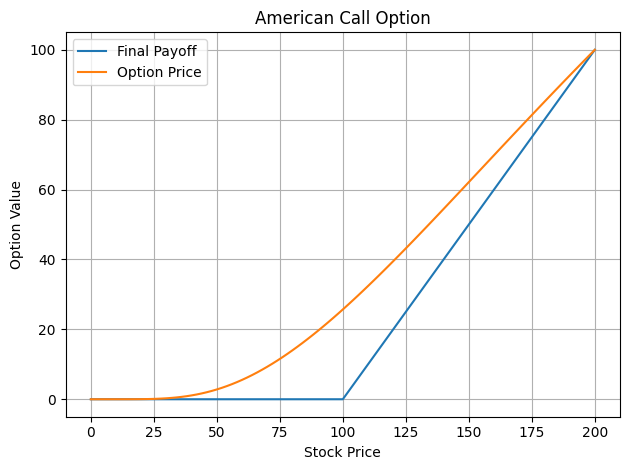

In [18]:
plt.plot(S, np.maximum(S - K, 0), label='Final Payoff')
plt.plot(S, V, label='Option Price')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('American Call Option')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/crank-nicolson-american.jpg', dpi=300)
plt.show()